<a href="https://colab.research.google.com/github/Agrover112/DL_Implementations/blob/master/GradCAM_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GradCAM - Gradient Class Activation Map

In [1]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git 
!pip install -U git+https://github.com/albumentations-team/albumentations 
!pip install --upgrade opencv-contrib-python 

Cloning into 'GradCAM-Dataset'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 193 (delta 0), reused 193 (delta 0), pack-reused 0
Receiving objects: 100% (193/193), 2.59 MiB | 16.35 MiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-3566fg_c
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-3566fg_c
  Resolved https://github.com/albumentations-team/albumentations to commit 2a1826d49c9442ae28cf33ddef658c8e24505cf8
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=124568 sha256=430a5e4588518f439d41c0fb6948492b5b7d11d8bc3ba13fa783f343ab5dc434
  Stored in directory: /tmp/pip-ephem-whee

In [20]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [127]:
import sys 
sys.path.append('/content/GradCAM-Dataset')

In [128]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import cv2

import torch 
from torch import nn 
import torch.nn.functional as F 

from torch.utils.data import DataLoader, Dataset 
from torchvision import datasets, transforms as T

from tqdm import tqdm 
import albumentations as A 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [129]:
CSV_FILE="/content/GradCAM-Dataset/train.csv"
DATA_DIR="/content/GradCAM-Dataset/"

BATCH_SIZE=16
EPOCHS=10
LR=0.001
class_list= {0:'cucumber',1:'eggplant',2:'mushroom'} # Corresponding to 
DEVICE='cuda'

def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(42)

In [130]:
data=pd.read_csv(CSV_FILE)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [131]:
train_df,valid_df=train_test_split(data,test_size=0.2,random_state=42)

# Augmentations

In [132]:
import albumentations as A
train_augs=A.Compose([
    A.Rotate(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Normalize()
]) 
valid_augs=A.Compose([
    A.Normalize()
])

# Load Image Dataset 

In [133]:
class ImageDataset(Dataset):

    def __init__(self, df, data_dir = None, augs = None,):
        self.df = df
        self.augs = augs
        self.data_dir = data_dir 

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        row = self.df.iloc[idx]

        img_path = self.data_dir + row.img_path
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        label = row.label 

        if self.augs:
            data = self.augs(image = img)
            img = data['image']

        img = torch.from_numpy(img).permute(2, 0, 1)

        return img, label


In [134]:
train_df.iloc[69].img_path

'train_images/cucumber_48.jpg'

In [135]:
trainset=utils.ImageDataset(train_df,augs=train_augs,data_dir=DATA_DIR)
validset=utils.ImageDataset(valid_df,augs=valid_augs,data_dir=DATA_DIR)

Text(0.5, 1.0, 'mushroom')

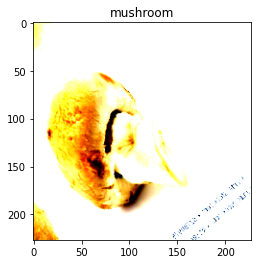

In [136]:
image,label=trainset[100] # c,h,w 

plt.imshow(image.permute(1,2,0))
plt.title(class_list.get(label))

In [137]:
print(f"No. of examples in the {len(trainset)}")
print(f"No. of examples in the {len(validset)}")

No. of examples in the 148
No. of examples in the 38


# Load Dataset into Batches

In [138]:
trainloader=DataLoader(trainset,shuffle=True,batch_size=BATCH_SIZE)
validloader=DataLoader(validset,shuffle=True,batch_size=BATCH_SIZE)

In [139]:
print(f"Total No. of images in trainloader : {len(trainloader.dataset)}")
print(f"No. of images in validloader : {len(validloader.dataset)}")

Total No. of images in trainloader : 148
No. of images in validloader : 38


In [140]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


In [141]:
for images,labels in trainloader:
  print(f"One batch image shape : {images.shape}")
  print(f"One batch label shape : {labels.shape}")
  break

One batch image shape : torch.Size([16, 3, 227, 227])
One batch label shape : torch.Size([16])


In [142]:
# Total no.of images[len(dataloader.dataset)]/BATCH_SIZE = Number of batches
148/16

9.25

# Create Model 

In [143]:
class ImageModel(nn.Module):
  def __init__(self): # Differrent activations
    super().__init__()
    self.feature_extractor= nn.Sequential(

      nn.Conv2d(in_channels=3,out_channels=16, kernel_size=(5,5),padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(4,4),stride=2),

      nn.Conv2d(in_channels=16,out_channels=16, kernel_size=(5,5),padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(4,4),stride=2),

      nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(5,5),padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(4,4),stride=2),

      nn.Conv2d(in_channels=32,out_channels=64, kernel_size=(5,5),padding=1),
      nn.ReLU()

    )
    self.maxpool=nn.MaxPool2d(kernel_size=(4,4),stride=2)
    self.classifier= nn.Sequential(
        nn.Flatten(),
        nn.Linear(6400,2048),
        nn.ReLU(),
        nn.Linear(2048,3)
    )
    self.gradient=None



  def activations_hook(self,grad):
      self.gradient=grad 

  def get_activations_gradient(self):
    return self.gradient
  
  def get_activations(self,x):
    return self.feature_extractor(x)


  def forward(self,images):
      x=self.feature_extractor(images)
      h=x.register_hook(self.activations_hook)
      x=self.maxpool(x)
      x=self.classifier(x)
      return x




In [144]:
model=ImageModel()
model.to(device='cuda')

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [145]:
def train_fn(dataloader,optimizer,model,criterion):

  model.train()
  total_loss=0.0
  total_correct = 0
  for images,labels in tqdm(dataloader):
    images=images.to(DEVICE)
    labels=labels.to(DEVICE)

    optimizer.zero_grad()
    logits=model(images)  #(16 batches, 3 probs)

    _,predicted = torch.max(logits, 1) #actual-max-values , Index of where the maximum value occurs out of the 3 places in (16,3)

    
    loss=criterion(logits,labels)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()


    total_correct += (predicted == labels).sum().item()

  
  return total_loss/len(dataloader),total_correct / len(dataloader.dataset) # avg.loss of 10 batches vs % of correc images of total images


In [146]:
def eval_fn(dataloader,model,criterion):
  model.eval()
  total_loss=0.0
  total_correct = 0
  for images,labels in tqdm(dataloader):
    images=images.to(DEVICE)
    labels=labels.to(DEVICE)

    logits=model(images)
    _, predicted = torch.max(logits, 1)

    loss=criterion(logits,labels)

    total_loss+=loss.item()
    total_correct += (predicted == labels).sum().item()

  
  return total_loss/len(dataloader),total_correct /len(dataloader.dataset)


# Training Loop

In [147]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)
criterion=torch.nn.CrossEntropyLoss()

In [148]:
best_loss=np.Inf
tacc=[]
vacc=[]
toss=[]
voss=[]
for i in range(EPOCHS):
    train_loss,train_acc=train_fn(trainloader,optimizer,model,criterion)
    valid_loss,val_acc=eval_fn(validloader,model,criterion)
    if valid_loss < best_loss:
      best_loss=valid_loss
      torch.save(model.state_dict(),'best_model.pt')

    print("Epoch : {} Training Loss: {} Validation Loss: {}  Training Acc: {} Validation Acc: {}".format(i+1,train_loss,valid_loss,train_acc*100,val_acc*100))
    tacc.append(train_acc)
    vacc.append(val_acc)
    toss.append(train_loss)
    voss.append(valid_loss)

100%|██████████| 3/3 [00:00<00:00, 31.13it/s]


Epoch : 1 Training Loss: 1.064805841445923 Validation Loss: 1.0713963309923809  Training Acc: 44.5945945945946 Validation Acc: 55.26315789473685


100%|██████████| 3/3 [00:00<00:00, 33.73it/s]


Epoch : 2 Training Loss: 0.6206823825836182 Validation Loss: 0.33957863599061966  Training Acc: 80.4054054054054 Validation Acc: 81.57894736842105


100%|██████████| 3/3 [00:00<00:00, 33.98it/s]


Epoch : 3 Training Loss: 0.4079774245619774 Validation Loss: 0.5379273941119512  Training Acc: 83.1081081081081 Validation Acc: 86.8421052631579


100%|██████████| 3/3 [00:00<00:00, 32.55it/s]


Epoch : 4 Training Loss: 0.2856927365064621 Validation Loss: 0.238434170683225  Training Acc: 89.86486486486487 Validation Acc: 89.47368421052632


100%|██████████| 3/3 [00:00<00:00, 31.80it/s]


Epoch : 5 Training Loss: 0.26939401142299174 Validation Loss: 0.46628409375747043  Training Acc: 89.86486486486487 Validation Acc: 84.21052631578947


100%|██████████| 3/3 [00:00<00:00, 35.30it/s]


Epoch : 6 Training Loss: 0.23044067658483983 Validation Loss: 0.389007310072581  Training Acc: 89.1891891891892 Validation Acc: 89.47368421052632


100%|██████████| 3/3 [00:00<00:00, 28.03it/s]


Epoch : 7 Training Loss: 0.16146988309919835 Validation Loss: 0.21615077555179596  Training Acc: 93.24324324324324 Validation Acc: 92.10526315789474


100%|██████████| 3/3 [00:00<00:00, 33.47it/s]


Epoch : 8 Training Loss: 0.12138863755390047 Validation Loss: 0.6053711522060136  Training Acc: 96.62162162162163 Validation Acc: 92.10526315789474


100%|██████████| 3/3 [00:00<00:00, 34.89it/s]


Epoch : 9 Training Loss: 0.2995939150452614 Validation Loss: 0.11656373242537181  Training Acc: 91.8918918918919 Validation Acc: 97.36842105263158


100%|██████████| 3/3 [00:00<00:00, 35.72it/s]

Epoch : 10 Training Loss: 0.17965593348490075 Validation Loss: 0.16767717991024256  Training Acc: 94.5945945945946 Validation Acc: 92.10526315789474


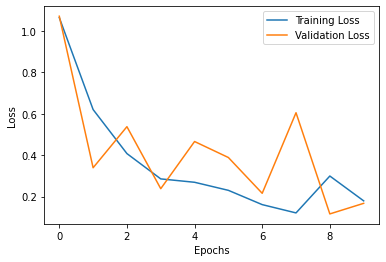

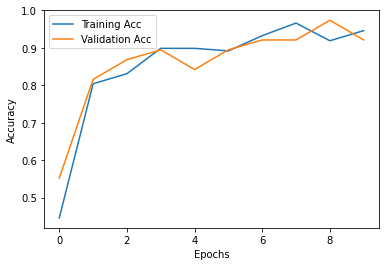

In [149]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(EPOCHS), toss, label='Training Loss')
plt.plot(range(EPOCHS), voss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(EPOCHS), tacc, label='Training Acc')
plt.plot(range(EPOCHS), vacc, label='Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Get GradCAM

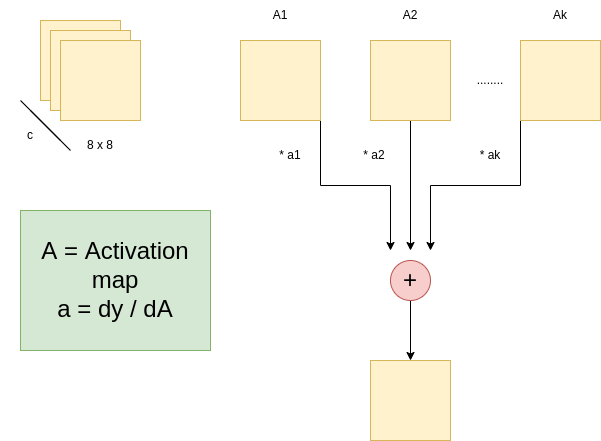

In [150]:
def get_gradcam(model,image,label,size):
  label.backward()
  grad=model.get_activations_gradient()
  print("Gradients:",grad.shape)
  pooled_grad=torch.mean(grad,dim=[0,2,3])
  print("Gradient weight vector:",pooled_grad.shape)
  activations=model.get_activations(image).detach()
  print("Feat Ext Embeddings",activations.shape)
  for i in range(activations.shape[1]):
    activations[:,i,:,:]*=pooled_grad[i]


  heatmap=torch.mean(activations,dim=1).squeeze().cpu()
  print("CAM before ReLU",heatmap.shape)
  heatmap=nn.ReLU()(heatmap)
  heatmap/=torch.max(heatmap)
  heatmap=cv2.resize(heatmap.numpy(),(size,size))
  return heatmap

tensor([[-3.9296,  7.7102, -2.3970]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Gradients: torch.Size([1, 64, 22, 22])
Gradient weight vector: torch.Size([64])
Feat Ext Embeddings torch.Size([1, 64, 22, 22])
CAM before ReLU torch.Size([22, 22])


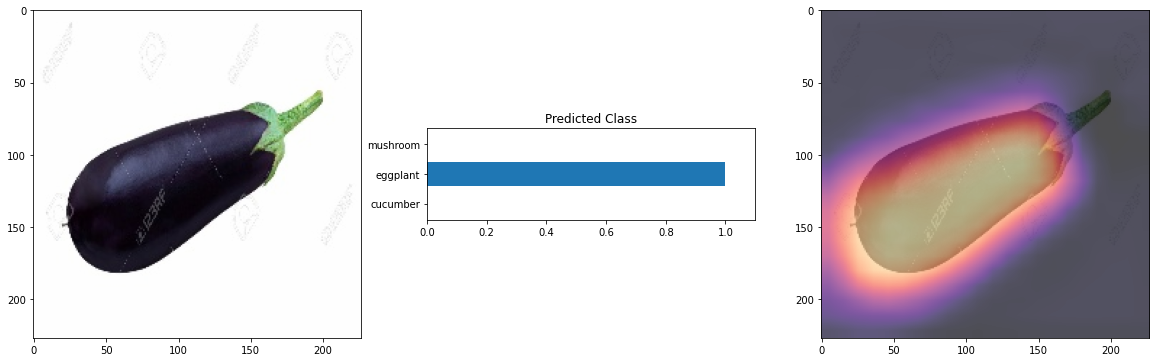

In [151]:
image,label=validset[4]
denorm_image=image.permute(1,2,0) * np.array((0.229,0.224,0.225)) +  np.array((0.485,0.456,0.406)) 

image=image.unsqueeze(0).to(DEVICE)
pred=model(image)
print(pred)
heatmap=get_gradcam(model,image,pred[0][1],size=227)
utils.plot_heatmap(denorm_image,pred,heatmap)